In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Text(0, 0.5, 'No. of Accidents')

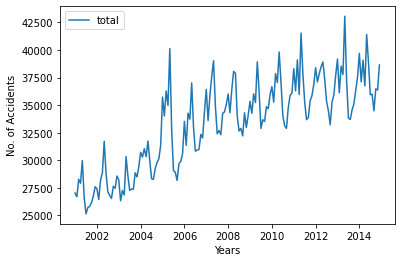

In [8]:
df = pd.read_csv('final_dataset_of_india.csv')
df = df.rename(columns = {'to_be_index' : 'Year'})
df = df.set_index('Year')
ax = df.plot()
ax.set_xlabel('Years')
ax.set_ylabel('No. of Accidents')
#ax1 = ax.get_figure()
#ax1.savefig('original_dataset.jpg')

In [9]:
#useful_functions
def getTrainTest(df):
    train = df.iloc[:144,:]
    test = df.iloc[144:168,:]
    return train, test
def cvt_to_array(train, test):
    trainAsArray = train.values
    testAsArray = test.values
    return trainAsArray, testAsArray
def cal_trend(trainAsArray):
    trend = np.zeros(12)
    for i in range(0,12):
        sum = 0
        for j in range(0,12):
            sum = sum + trainAsArray[12*i + j]
        trend[i] = sum/12
    return trend
def getTrend(trend):
    y = np.array([[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [7, 0], [8, 0], [9, 0], [10,0], [11,0],[12,0]])
    reg = LinearRegression().fit(y, trend)
    trend_for_2013 = reg.predict([[13,0]])
    trend_for_2014 = reg.predict([[14,0]])
    return trend_for_2013, trend_for_2014
def detrend(trainAsArray, trend):
    dtrend = np.zeros(144)
    for i in range(0,12):
        for j in range(0,12):
            dtrend[12*j + i] = trainAsArray[12*j + i] - trend[j]
    return dtrend
def de_sea(dtrend):
    seas = np.zeros(12)
    sum=0
    for i in range(0,12):
        sum = 0
        for j in range(0,12):
            sum = sum + dtrend[12*j+i]
        seas[i] = sum/12
    final = np.zeros(144)
    for i in range(0,12):
        for j in range(0,12):
            final[12*j + i] = dtrend[12*j + i] - seas[i]
    return final,seas
def forecasting(final_dataFrame, p, d, q):
    model1 = ARIMA(final_dataFrame, order = (p,d,q))
    model1_fit = model1.fit()
    aic = model1_fit.aic
    forecast = model1_fit.forecast(steps = 24)[0]
    return model1_fit, forecast, aic
def Adding_comp(forecast, seas, trend_for_2013, trend_for_2014):
    duhh_ = forecast
    for i in range(0,24):
        if i<12:
            duhh_[i] = duhh_[i] + trend_for_2013 + seas[i]
        else:
            duhh_[i] = duhh_[i] + trend_for_2014 + seas[i-12]
    return duhh_
def test_data(testAsArray):
    duhh1 = np.zeros(24)
    j=0
    for i in range(0,24):
        duhh1[j] = testAsArray[i]
        j = j+1
    return duhh1

In [10]:
train, test = getTrainTest(df)

In [11]:
trainAsArray, testAsArray = cvt_to_array(train, test)
faltu = np.zeros(144)
j=0
for i in range(0,144):
    faltu[j] = trainAsArray[i]
    j = j+1

In [12]:
trend = cal_trend(trainAsArray)
#trend_plot = pd.DataFrame(trend).plot()
#trend_plot.legend(['total'])
#trend_plot.set_xlabel('Years')
#trend_plot.set_ylabel('No. of Accidents')
#trend_plot.get_figure().savefig('trend.jpg')

In [13]:
#trend_for_2013, trend_for_2014 = getTrend(trend)

In [14]:
dtrend = detrend(trainAsArray, trend)
#plot_acf(pd.DataFrame(dtrend), lags=30)

In [15]:
orig_deseason, orig_seas = de_sea(trainAsArray)
#orig_deseason, orig_seas = de_sea(dtrend)

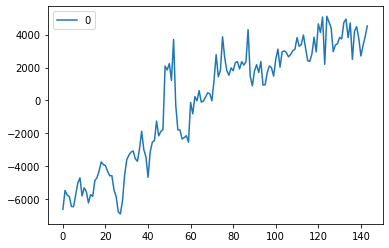

In [16]:
pd.DataFrame(orig_deseason).plot()

In [17]:
#seas_plot = pd.DataFrame(orig_seas).plot()
#seas_plot.legend(['total'])
#seas_plot.set_xlabel('Months')
#seas_plot.set_ylabel('No. of Accidents')
#seas_plot.get_figure().savefig('seas.jpg')

In [18]:
deseason_data, seas = de_sea(dtrend)

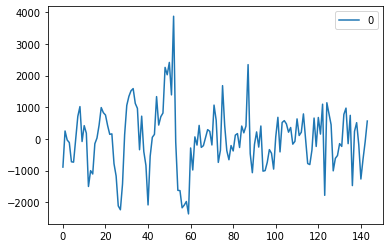

In [19]:
pd.DataFrame(deseason_data).plot()

In [20]:
#residual_plot = pd.DataFrame(orig_deseason).plot()
#residual_plot.legend(['total'])
#residual_plot.set_xlabel('Years')
#residual_plot.set_ylabel('')
#residual_plot.get_figure().savefig('residual.jpg')

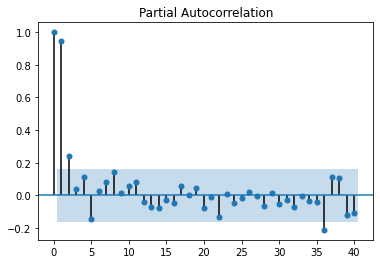

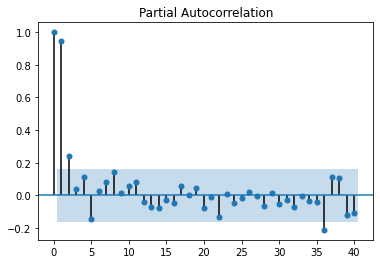

In [21]:
plot_pacf(pd.DataFrame(orig_deseason), lags=40)
#plot_pacf(pd.DataFrame(deseason_data), lags=40)

In [22]:
final_dataFrame = pd.DataFrame(orig_deseason)

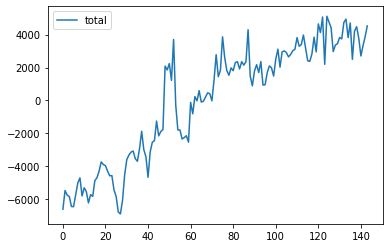

In [23]:
final_dataFrame = final_dataFrame.rename(columns = {0:'total'})
final_dataFrame.plot()

In [24]:
model_fit, forecast,aic = forecasting(final_dataFrame.total, 3,1,0)

NormaltestResult(statistic=10.826607347349055, pvalue=0.004456891746771268)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


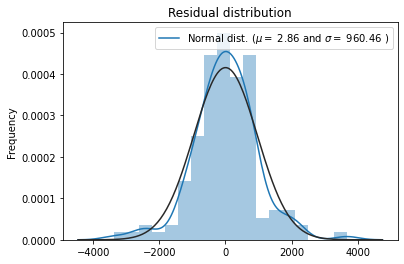

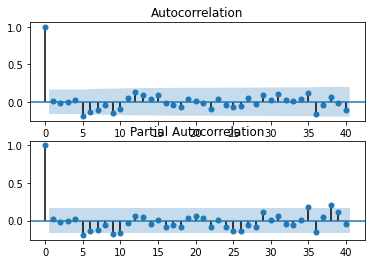

In [25]:
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest

resid = model_fit.resid
print(normaltest(resid))

fig = plt.figure(figsize=(6,4))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

# ACF and PACF
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(211)
fig = plot_acf(resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(resid, lags=40, ax=ax2)

In [26]:
final_pred = Adding_comp(forecast, orig_seas, 0, 0)#trend_for_2013, trend_for_2014)

In [27]:
testAsArray = test.values

In [28]:
true_data = test_data(testAsArray)

In [29]:
true_data.mean()

37245.791666666664

In [30]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(true_data, final_pred)

950.1801927358468

In [31]:
np.sqrt(mean_squared_error(true_data, final_pred))

1157.788669662713

In [32]:
aic

2379.928151348001

In [33]:
names = {'true_data' : true_data, 'pred_data' : final_pred}

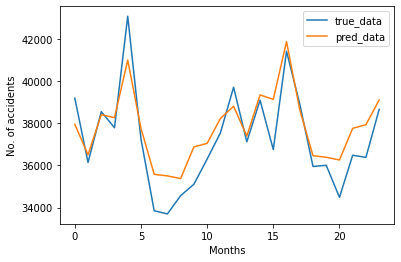

In [34]:
trueVpred = pd.DataFrame(names).plot()
trueVpred.set_xlabel('Months')
trueVpred.set_ylabel('No. of accidents')
trueVpred.get_figure().savefig('trueVpred.jpg')

In [35]:
pd.DataFrame(names)

,true_data,pred_data
0,39185.0,37948.874203
1,36137.0,36497.277631
2,38543.0,38402.039229
3,37782.0,38258.257932
4,43064.0,40986.340126
5,37249.0,37755.446011
6,33847.0,35573.837166
7,33698.0,35499.529136
8,34565.0,35372.574815
9,35103.0,36874.489656


In [36]:
temp_df = pd.DataFrame(train)

In [37]:
first_diff = temp_df.total - temp_df.total.shift(1)
first_diff = first_diff.dropna(inplace = False)
#test_stationarity(first_diff, window = 12)
first_df = pd.DataFrame(first_diff)
first_df

,total
Year,
2001.083333,-345.0
2001.166667,1590.0
2001.250000,-363.0
2001.333333,2057.0
2001.416667,-3318.0
...,...
2012.583333,-847.0
2012.666667,-1283.0
2012.750000,2052.0


In [38]:
val = first_df.values

In [39]:
duhh1 = np.zeros(143)
j=0
for i in range(143):
    duhh1[j] = val[i]
    j = j+1

In [40]:
#augmented dickey fuller test
from statsmodels.tsa.stattools import adfuller
#X = series.values
result = adfuller(dtrend)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.665228
p-value: 0.000098
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
